<a href="https://colab.research.google.com/github/arenalmeida/designoptimization/blob/main/hw3_prob1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# HW3 MAE 598 
# Aren Almeida 1225408288
# problem 1
# importing libraries

import numpy as np
from IPython import *
import torch
from torch.autograd import *

import matplotlib.pyplot as plt

# array of x1 which is for water
X = np.array([[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
x=X

# flipping the orientation
Y = np.flip(x, axis=1).copy() 
y=Y
# setting a array for water and 1,4 dioxane
ai = np.array(([[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]]))

# temperature is 20
Temp = 20

# pressure for water and dioxane
p_w = 10 ** (ai[0, 0] - ai[0, 1] / (Temp + ai[0, 2]))
p_di = 10 ** (ai[1, 0] - ai[1, 1] / (Temp + ai[1, 2]))

# pressure array
Pres = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])

P = torch.tensor(Pres, requires_grad=False, dtype=torch.float32)
p_t1=P 
# pressure converted to tensor
A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)
a_t=A
# A,x_1,x_2 converted to tensor
x_1 = torch.tensor(x, requires_grad=False, dtype=torch.float32)
x_t1=x_1
x_2 = torch.tensor(y, requires_grad=False, dtype=torch.float32)
x_t2=x_2

# initial ai

ai = 0.001

# iterating for predicting pressure
for n in range(100):
    predic_p = x_t1 * torch.exp(a_t[0] * (a_t[1] * x_t2 / (a_t[0] * x_t1 + a_t[1] * x_t2)) ** 2) * p_w +  x_t2 * torch.exp(a_t[1] * (a_t[0] * x_t1 / (a_t[0] * x_t1 + a_t[1] * x_t2)) ** 2) * p_di
# loss calculated
    loss = (predic_p - p_t1) ** 2
    loss = loss.sum()
    loss.backward()
    with torch.no_grad():
        a_t -= ai * a_t.grad
        a_t.grad.zero_()

# printing a12 and a21 and final loss occured
print('Estimated A_12 and A_21 are:',a_t)
print('Final loss occured is:',loss.data.numpy())

Estimated A_12 and A_21 are: tensor([1.9584, 1.6892], requires_grad=True)
Final loss occured is: 0.67019325


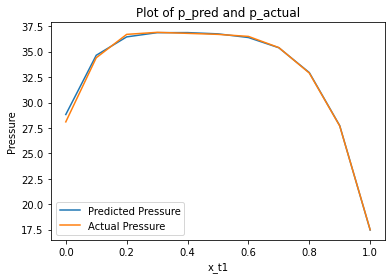

In [2]:
# plotting graph of Predicted Pressure and Actual Pressure
import matplotlib.pyplot as plt
predic_p = predic_p.detach().numpy()[0]
p_t1 = p_t1.detach().numpy()[0]
x_t1 = x_t1.detach().numpy()[0]

plt.plot(x_t1, predic_p, label='Predicted Pressure')
plt.plot(x_t1, p_t1, label='Actual Pressure')
plt.xlabel('x_t1')
plt.ylabel('Pressure')
plt.legend()
plt.title('Plot of p_pred and p_actual')
plt.show()

In [3]:
# Problem 2 
# importing libraries

import numpy as np
from scipy.stats import *
from scipy.optimize import minimize
import sklearn.gaussian_process as gp

# Expected improvement function
def imp_exp(x, gaussian_process, evaluated_loss, bool=False, n_hyppar=1):

    x_pred = x.reshape(-1, n_hyppar)
    mu, sig = gaussian_process.predict(x_pred, return_std=True)

    if bool:
        opti = np.max(evaluated_loss)
    else:
        opti = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not bool)

    # In case sig equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - opti) / sig
        imp_exp = scaling_factor * (mu - opti) * norm.cdf(Z) + sig * norm.pdf(Z)
        imp_exp[sig == 0.0] == 0.0

    return -1 * imp_exp

#sampling loss function
def loss_samp_hype(func_acqui, gaussian_process, evaluated_loss, bool=False,bound=(0, 10), n_restarts=25):
    best_x = None
    best_acquisition_value = 1
    n_hyppar = bound.shape[0]

    for starting_point in np.random.uniform(bound[:, 0], bound[:, 1], size=(n_restarts, n_hyppar)):

        res = minimize(fun=func_acqui,X0=starting_point.reshape(1, -1),bound=bound,method='L-BFGS-B',args=(gaussian_process, evaluated_loss, bool, n_hyppar))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

# using gaussian process to optimize the loss where alpha is variance and epsilon is tolerance
def bayesian_optimisation(iterations, loss, bound, X0=None, n_iniloss=5,gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):

    x_list = []
    y_list = []

    n_hyppar = bound.shape[0]

    if X0 is None:
        for params in np.random.uniform(bound[:, 0], bound[:, 1], (n_iniloss, bound.shape[0])):
            x_list.append(params)
            y_list.append(loss(params))
    else:
        for params in X0:
            x_list.append(params)
            y_list.append(loss(params))
# array of x and y
    arr_x = np.array(x_list)
    arr_y = np.array(y_list)

    # Create the gaussian process
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
        
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,alpha=alpha,n_restarts_optimizer=10,normalize_y=True)
        
# taking iterations
    for n in range(iterations):
        model.fit(arr_x, arr_y)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bound[:, 0], bound[:, 1], size=(random_search, n_hyppar))
            ei = -1 * imp_exp(x_random, model, arr_y, bool=True, n_hyppar=n_hyppar)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = loss_samp_hype(imp_exp, model, arr_y, bool=True, bound=bound, n_restarts=100)

        # Duplicates will break the gaussian process.
        if np.any(np.abs(next_sample - arr_x) <= epsilon):
            next_sample = np.random.uniform(bound[:, 0], bound[:, 1], bound.shape[0])

        # Sample loss for new parameters
        cv_score = loss(next_sample)

        # Updating x and y lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update array of x and y
        arr_x = np.array(x_list)
        arr_y = np.array(y_list)

    return arr_x, arr_y
# objective function
def loss(params):

    return (4 - 2.1 * params[0] ** 2 + params[0] ** 4 / 3) * params[0] ** 2 + params[0] * params[1] + (-4 + 4 * params[1] ** 2) * params[1] ** 2

bound = np.array([[-3, 3], [-2, 2]])

arr_x, arr_y = bayesian_optimisation(iterations=30,loss=loss,bound=bound,n_iniloss=20,random_search=1000)
# printing the results
print('minimized obj func:', np.min(arr_y))
print('X1 X2 when obj func is minimized:',arr_x[np.argmin(arr_y)])
print('solution for X1 X2:', arr_x)
print('obj func:', arr_y)

minimized obj func: -0.7379117233528504
X1 X2 when obj func is minimized: [0.13055516 0.57173893]
solution for X1 X2: [[-0.43429166  0.6482685 ]
 [-0.60926463  0.07335662]
 [-0.94725268 -0.81598978]
 [ 1.22824701  0.08067967]
 [ 2.27919395  0.25822815]
 [-2.34383968 -0.25818648]
 [ 0.02224428  1.88185098]
 [-1.5751139   1.94163631]
 [-0.15246224  0.17943608]
 [-1.32629202 -0.37243424]
 [ 1.5349921   0.78842281]
 [-2.71636183 -0.78424431]
 [ 2.48796848  0.70672021]
 [ 1.76659732  0.87722235]
 [ 0.13055516  0.57173893]
 [-1.28164002 -1.56976407]
 [-1.04119807 -1.62621874]
 [ 1.11731536 -1.81514326]
 [-1.37149752  1.34074944]
 [ 1.87395753  0.46945817]
 [-2.82967024 -0.99509845]
 [-2.85855749 -1.27435382]
 [-2.98801754 -1.4292352 ]
 [-2.9992485  -1.82407576]
 [-2.96079201 -1.86905903]
 [ 2.97296136 -1.91475841]
 [ 2.99593331 -1.3968248 ]
 [ 2.29967785 -1.98755419]
 [-2.95431589  1.97990763]
 [-2.89505295  1.29449412]
 [-2.68450292  1.98425715]
 [ 2.76284696  1.87431468]
 [ 2.09459047  1.9

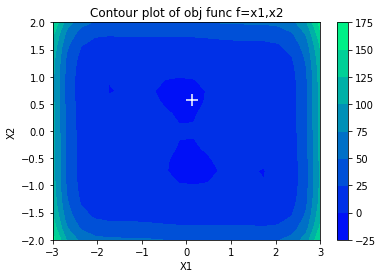

In [4]:
# plotting function
import matplotlib.pyplot as plt
X1 = np.linspace(-3, 3, 20)
X2 = np.linspace(-2, 2, 20)

param_grid = np.array([[x1, x2] for x2 in X2 for x1 in X1])
real_loss = [loss(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)
result = np.array(real_loss).reshape(C.shape)
plt.figure()
im = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap='winter')
plt.colorbar(im)
plt.scatter(arr_x[np.argmin(arr_y)][0], arr_x[np.argmin(arr_y)][1], marker='+', c='white', s=150)
plt.title('Contour plot of obj func f=x1,x2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()